# **House Prices Advanced Regression Project Team 1**

In [41]:
# Import necessary libraries (shap removed due to DLL loading issues)
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("✓ Libraries imported successfully!")
print(f"  • NumPy version: {np.__version__}")
print(f"  • Pandas version: {pd.__version__}")
print(f"  • Matplotlib version: {matplotlib.__version__}")
print(f"  • Seaborn version: {sns.__version__}")

✓ Libraries imported successfully!
  • NumPy version: 2.4.1
  • Pandas version: 2.3.3
  • Matplotlib version: 3.10.8
  • Seaborn version: 0.13.2


In [42]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [43]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# **A) Data Loading and Inspection**

In [44]:
try:
    train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
    test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
except FileNotFoundError:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

In [45]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [46]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [50]:

summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Rows": [train_df.shape[0], test_df.shape[0]],
    "Columns": [train_df.shape[1], test_df.shape[1]],
    "Missing Values": [train_df.isnull().sum().sum(), test_df.isnull().sum().sum()]
})

display(summary)

,Dataset,Rows,Columns,Missing Values
0,Train,1460,81,7829
1,Test,1459,80,7878


In [51]:
print("Duplicated records in train set:", train_df.duplicated().sum())
print("Duplicated records in test set:", test_df.duplicated().sum())

Duplicated records in train set: 0
Duplicated records in test set: 0


# **B) EDA (Exploratory Data Analysis)**

**1. Target Analysis (SalePrice)**

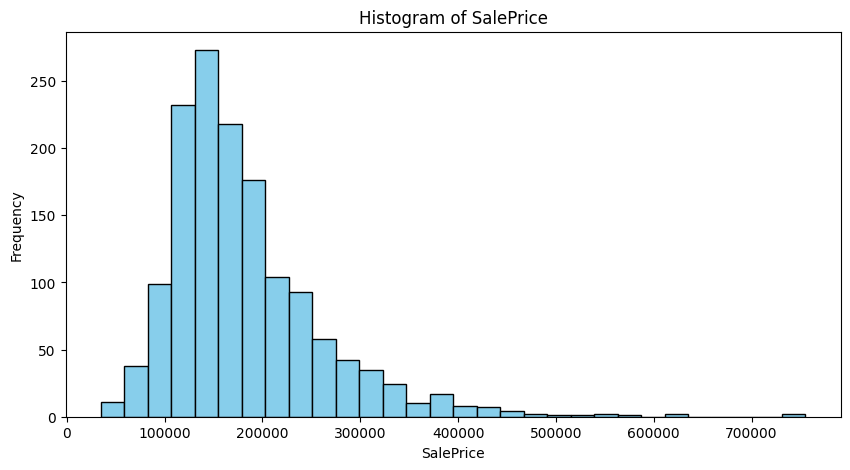

In [52]:
# a. Histogram of SalePrice
plt.figure(figsize=(10,5))
plt.hist(train_df['SalePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

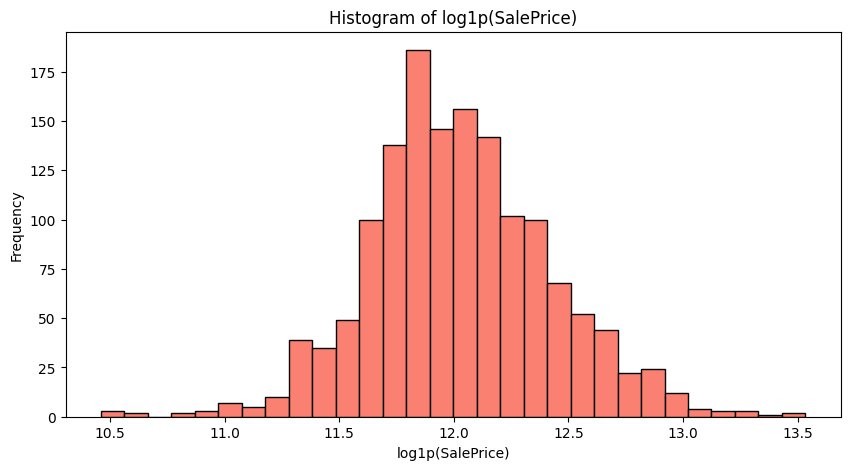

In [53]:
# b. Histogram of log1p(SalePrice)
plt.figure(figsize=(10,5))
plt.hist(np.log1p(train_df['SalePrice']), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')
plt.ylabel('Frequency')
plt.show()

In [54]:
# c. Skewness Check
print("SalePrice Skewness:", train_df['SalePrice'].skew())
print("log1p(SalePrice) Skewness:", np.log1p(train_df['SalePrice']).skew())

SalePrice Skewness: 1.8828757597682129
log1p(SalePrice) Skewness: 0.12134661989685333


**2. Missing Value Analysis**

              MissingCount  MissingPercent
PoolQC                1453       99.520548
MiscFeature           1406       96.301370
Alley                 1369       93.767123
Fence                 1179       80.753425
MasVnrType             872       59.726027
FireplaceQu            690       47.260274
LotFrontage            259       17.739726
GarageType              81        5.547945
GarageYrBlt             81        5.547945
GarageFinish            81        5.547945
GarageQual              81        5.547945
GarageCond              81        5.547945
BsmtExposure            38        2.602740
BsmtFinType2            38        2.602740
BsmtQual                37        2.534247
BsmtCond                37        2.534247
BsmtFinType1            37        2.534247
MasVnrArea               8        0.547945
Electrical               1        0.068493


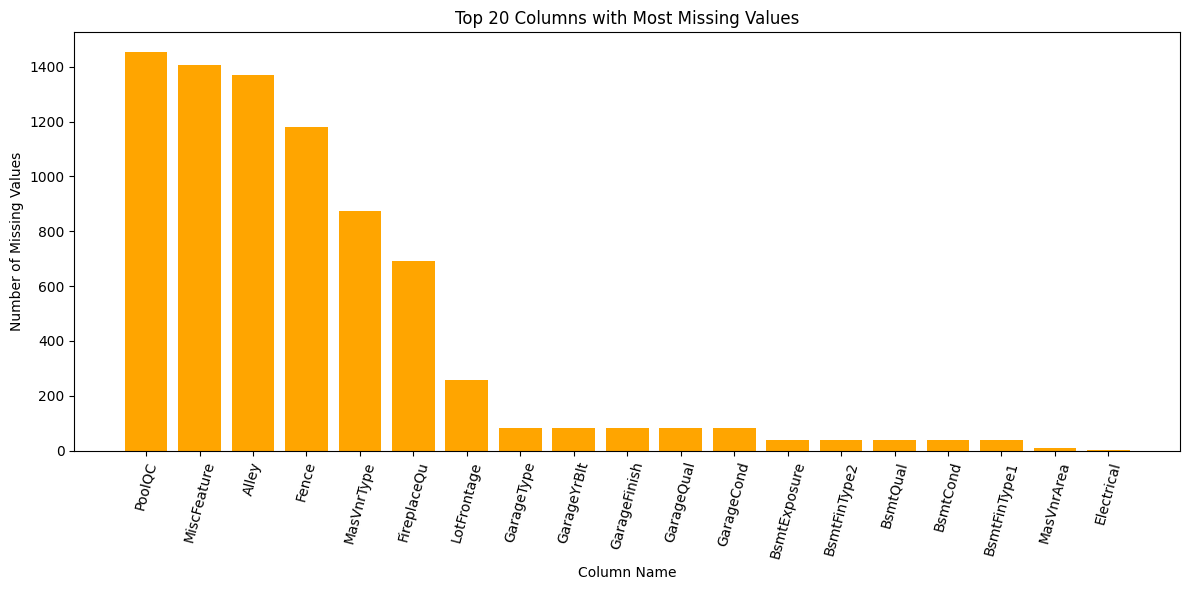

In [55]:
# 1. Her sütundaki eksik değer sayısını bul
missing_counts = train_df.isnull().sum()

# 2. Eksik değeri olan sütunları ve oranlarını bul, en çok eksik olan ilk 20 sütunu seç
missing_percent = (missing_counts / len(train_df)) * 100
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingPercent': missing_percent
})
missing_df = missing_df[missing_df['MissingCount'] > 0]
missing_df = missing_df.sort_values(by='MissingCount', ascending=False).head(20)

# 3. Sonuçları yazdır
print(missing_df)

# 4. Bar plot ile görselleştir
plt.figure(figsize=(12,6))
plt.bar(missing_df.index, missing_df['MissingCount'], color='orange')
plt.xticks(rotation=75)
plt.title('Top 20 Columns with Most Missing Values')
plt.ylabel('Number of Missing Values')
plt.xlabel('Column Name')
plt.tight_layout()
plt.show()

**3. Correlation Analysis (Numerical)**

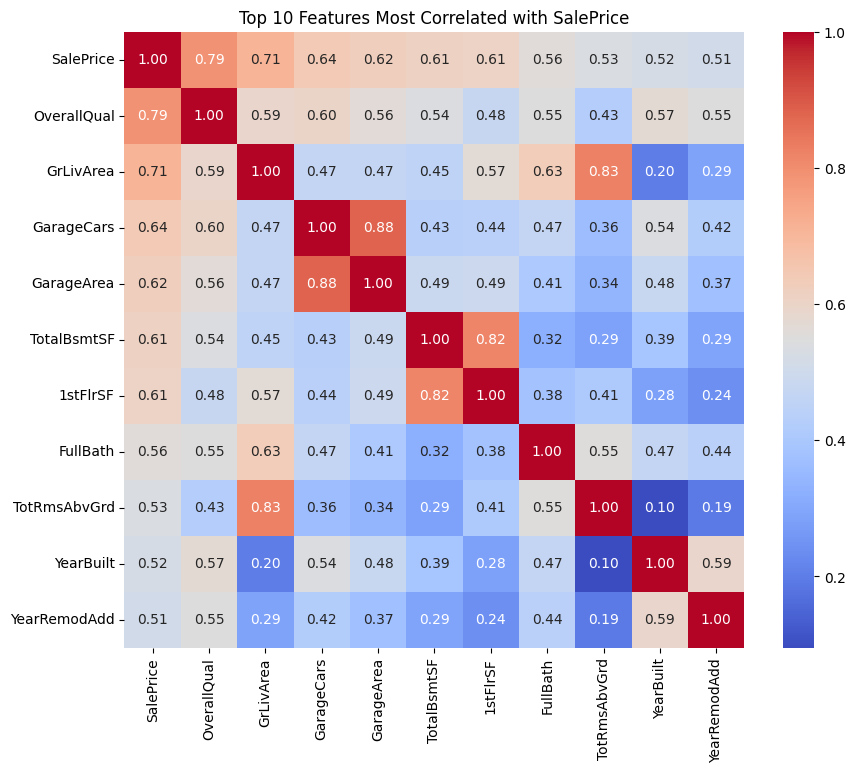

In [56]:


# Sadece sayısal sütunları seç
numeric_cols = train_df.select_dtypes(include=['number'])

# Korelasyon matrisini hesapla
corr_matrix = numeric_cols.corr()

# SalePrice ile en yüksek korelasyona sahip 10 özelliği bul
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(11).index  # 11 çünkü SalePrice kendisi de dahil

# Bu özelliklerin korelasyon matrisini al
top_corr_matrix = corr_matrix.loc[top_corr_features, top_corr_features]

# Isı haritası çiz
plt.figure(figsize=(10,8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top 10 Features Most Correlated with SalePrice')
plt.show()

**4. Feature vs. SalePrice Visualizations**

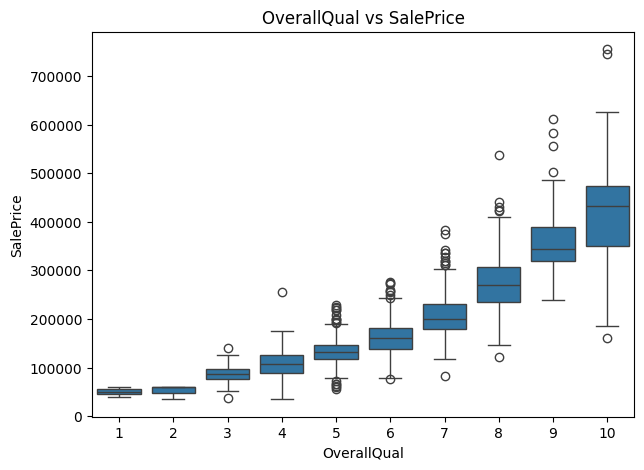

Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.


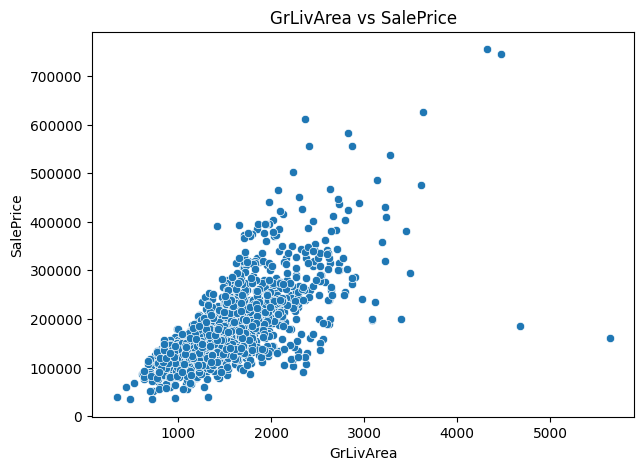

Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.


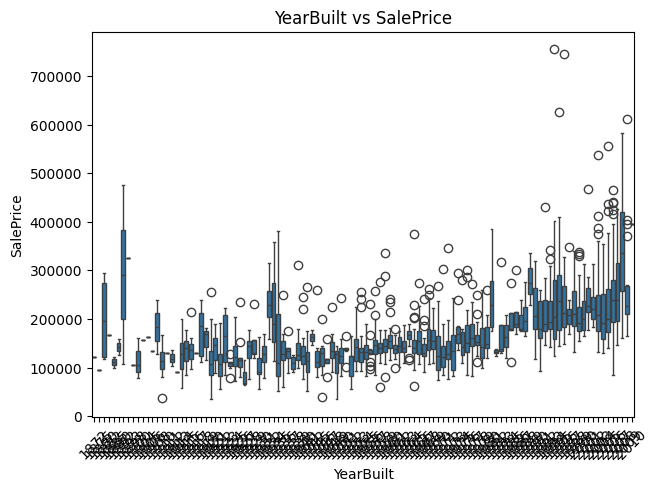

Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.


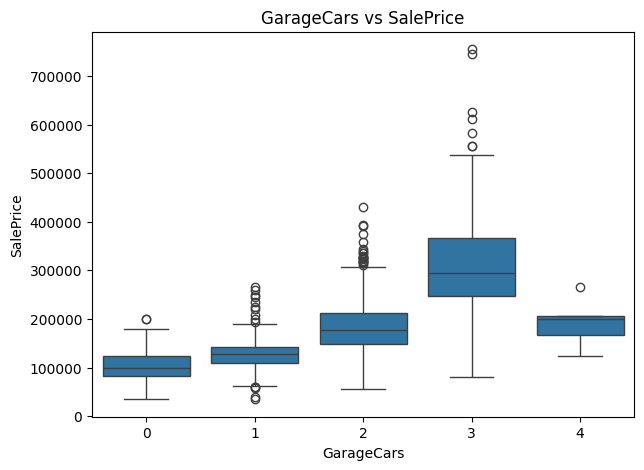

Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.


In [57]:
# 1. OverallQual vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('OverallQual vs SalePrice')
plt.show()
print("Yorum: Genel malzeme ve işçilik kalitesi (OverallQual) arttıkça, evin satış fiyatı da belirgin şekilde artıyor.")

# 2. GrLivArea vs SalePrice
plt.figure(figsize=(7,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('GrLivArea vs SalePrice')
plt.show()
print("Yorum: Yaşanabilir alan (GrLivArea) arttıkça, satış fiyatı da genellikle artıyor. Ancak bazı uç değerler (outlier) gözlemleniyor.")

# 3. YearBuilt vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df)
plt.xticks(rotation=45)
plt.title('YearBuilt vs SalePrice')
plt.show()
print("Yorum: Daha yeni inşa edilen evlerin satış fiyatı genellikle daha yüksek. Zamanla fiyatlarda artış eğilimi var.")

# 4. GarageCars vs SalePrice
plt.figure(figsize=(7,5))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_df)
plt.title('GarageCars vs SalePrice')
plt.show()
print("Yorum: Garaj kapasitesi arttıkça, evin satış fiyatı da artma eğiliminde. 3 veya daha fazla araçlık garajlar yüksek fiyatlarla ilişkilendiriliyor.")

# **C) Data Cleaning (MANDATORY)**
## **1. Filling Missing Values**

In [58]:
# Numerical ve Categorical sütunları belirle
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# 'Id' ve 'SalePrice' numerical_cols'tan çıkar
if 'Id' in numerical_cols:
    numerical_cols.remove('Id')
if 'SalePrice' in numerical_cols:
    numerical_cols.remove('SalePrice')

print("Numerical Columns:", len(numerical_cols))
print(numerical_cols[:10])  # İlk 10 sütunu göster
print("\nCategorical Columns:", len(categorical_cols))
print(categorical_cols)

Numerical Columns: 36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']

Categorical Columns: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [59]:
# Eksik değerleri olan sütunlar
missing_summary = pd.DataFrame({
    'Column': train_df.columns,
    'MissingCount': train_df.isnull().sum().values,
    'MissingPercent': (train_df.isnull().sum().values / len(train_df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['MissingCount'] > 0].sort_values('MissingCount', ascending=False)
print("Missing Values Summary:")
print(missing_summary)

Missing Values Summary:
          Column  MissingCount  MissingPercent
72        PoolQC          1453           99.52
74   MiscFeature          1406           96.30
6          Alley          1369           93.77
73         Fence          1179           80.75
25    MasVnrType           872           59.73
57   FireplaceQu           690           47.26
3    LotFrontage           259           17.74
58    GarageType            81            5.55
59   GarageYrBlt            81            5.55
60  GarageFinish            81            5.55
63    GarageQual            81            5.55
64    GarageCond            81            5.55
32  BsmtExposure            38            2.60
35  BsmtFinType2            38            2.60
30      BsmtQual            37            2.53
31      BsmtCond            37            2.53
33  BsmtFinType1            37            2.53
26    MasVnrArea             8            0.55
42    Electrical             1            0.07


In [60]:
# 1. NUMERICAL COLUMNS - MEDIAN ile doldur
from sklearn.impute import SimpleImputer

numerical_imputer = SimpleImputer(strategy='median')
train_df[numerical_cols] = numerical_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = numerical_imputer.transform(test_df[numerical_cols])

print("✓ Numerical columns filled with MEDIAN")
print(f"  - {len(numerical_cols)} numerical columns processed")

✓ Numerical columns filled with MEDIAN
  - 36 numerical columns processed


In [61]:
# 2. CATEGORICAL COLUMNS - None ve Most Frequent
# Özel columns: GarageType, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2,
#               FireplaceQu, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, Alley, MiscFeature

# Bu sütunlarda "NA" / "None" MEANINGFUL bir kategori
meaningful_none_cols = [
    'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'Alley', 'MiscFeature'
]

# "None" ile doldur (meaningful olduğu için)
for col in meaningful_none_cols:
    if col in train_df.columns:
        train_df[col].fillna('None', inplace=True)
        test_df[col].fillna('None', inplace=True)

print(f"✓ Meaningful 'None' columns filled: {len([c for c in meaningful_none_cols if c in train_df.columns])} columns")

# Kalan categorical columns - most_frequent ile doldur
categorical_imputer = SimpleImputer(strategy='most_frequent')
remaining_cat_cols = [col for col in categorical_cols if col not in meaningful_none_cols]

if remaining_cat_cols:
    train_df[remaining_cat_cols] = categorical_imputer.fit_transform(train_df[remaining_cat_cols])
    test_df[remaining_cat_cols] = categorical_imputer.transform(test_df[remaining_cat_cols])
    print(f"✓ Remaining categorical columns filled with MOST_FREQUENT: {len(remaining_cat_cols)} columns")
else:
    print("✓ No remaining categorical columns to fill with most_frequent")

print("\n✓ Data Cleaning COMPLETED - All missing values filled!")

✓ Meaningful 'None' columns filled: 14 columns
✓ Remaining categorical columns filled with MOST_FREQUENT: 29 columns

✓ Data Cleaning COMPLETED - All missing values filled!


In [62]:
# Verification: Check if any missing values remain
print("Verification - Remaining Missing Values:")
print(f"Train set - Total missing: {train_df.isnull().sum().sum()}")
print(f"Test set - Total missing: {test_df.isnull().sum().sum()}")

if train_df.isnull().sum().sum() == 0 and test_df.isnull().sum().sum() == 0:
    print(" SUCCESS! All missing values have been filled.")
else:
    print("\n⚠️ WARNING: Some missing values still exist!")
    print("\nTrain set missing values:")
    print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
    print("\nTest set missing values:")
    print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

Verification - Remaining Missing Values:
Train set - Total missing: 0
Test set - Total missing: 0
 SUCCESS! All missing values have been filled.


## **2. Outlier Handling**

OUTLIER HANDLING METHOD 1: GrLivArea vs SalePrice Anomaly


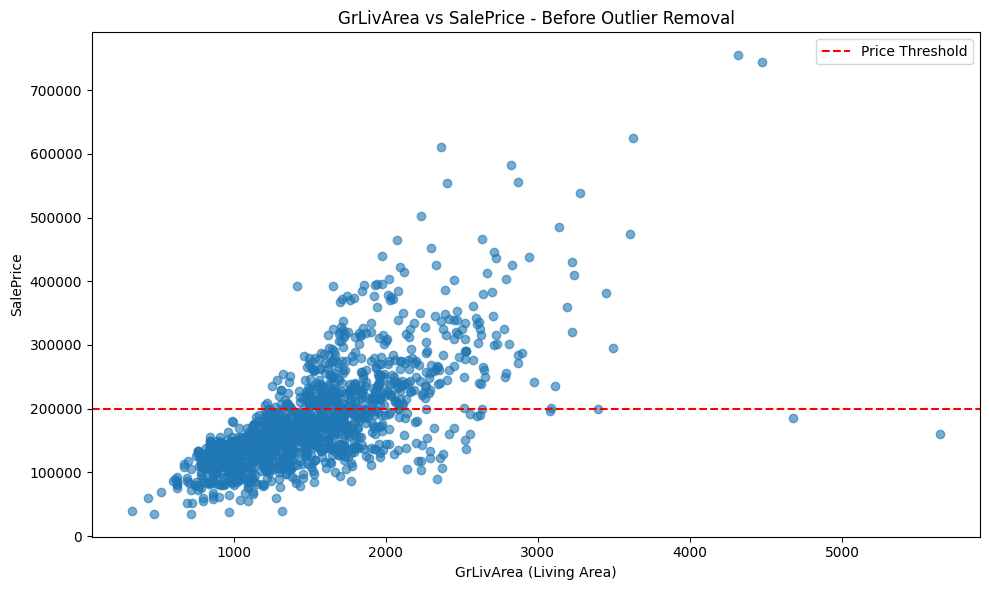


Initial train set shape: (1460, 81)

Found 2 outliers to remove:
      GrLivArea  SalePrice  OverallQual
523      4676.0     184750         10.0
1298     5642.0     160000         10.0

✓ Removed 2 outlier(s)
New train set shape: (1458, 81)


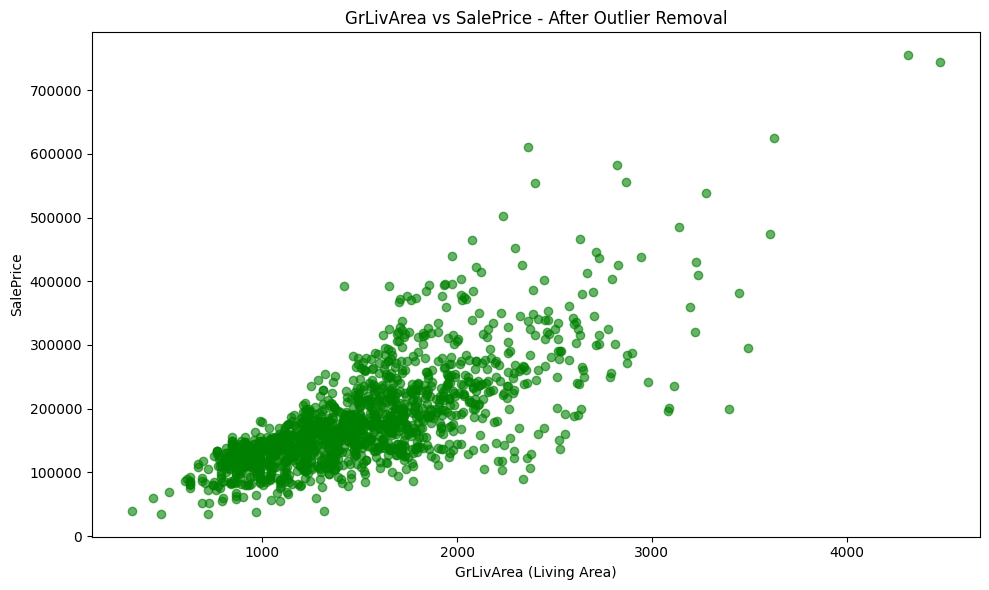

In [63]:
# Method 1: Identify and remove unrealistic houses (GrLivArea vs SalePrice anomaly)
print("=" * 60)
print("OUTLIER HANDLING METHOD 1: GrLivArea vs SalePrice Anomaly")
print("=" * 60)

# Visualize the relationship first
plt.figure(figsize=(10, 6))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.6)
plt.xlabel('GrLivArea (Living Area)')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice - Before Outlier Removal')
plt.axhline(y=200000, color='r', linestyle='--', label='Price Threshold')
plt.legend()
plt.tight_layout()
plt.show()

print("\nInitial train set shape:", train_df.shape)

# Remove rows where GrLivArea > 4000 but SalePrice < 200000 (unrealistic)
# These are likely data entry errors
outlier_mask = (train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)
outlier_count = outlier_mask.sum()

if outlier_count > 0:
    print(f"\nFound {outlier_count} outliers to remove:")
    print(train_df[outlier_mask][['GrLivArea', 'SalePrice', 'OverallQual']])
    
    train_df = train_df[~outlier_mask]
    print(f"\n✓ Removed {outlier_count} outlier(s)")
    print(f"New train set shape: {train_df.shape}")
else:
    print("\nNo outliers found with this criterion")

# Visualize after removal
plt.figure(figsize=(10, 6))
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.6, color='green')
plt.xlabel('GrLivArea (Living Area)')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs SalePrice - After Outlier Removal')
plt.tight_layout()
plt.show()

In [64]:
# Method 2: IQR (Interquartile Range) method for SalePrice
print("\n" + "=" * 60)
print("OUTLIER HANDLING METHOD 2: IQR Method on SalePrice")
print("=" * 60)

Q1_price = train_df['SalePrice'].quantile(0.25)
Q3_price = train_df['SalePrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_bound = Q1_price - 1.5 * IQR_price
upper_bound = Q3_price + 1.5 * IQR_price

print(f"\nSalePrice Statistics:")
print(f"  Q1 (25%): ${Q1_price:,.0f}")
print(f"  Q3 (75%): ${Q3_price:,.0f}")
print(f"  IQR: ${IQR_price:,.0f}")
print(f"  Lower Bound: ${lower_bound:,.0f}")
print(f"  Upper Bound: ${upper_bound:,.0f}")

# Find outliers based on IQR
price_outliers = (train_df['SalePrice'] < lower_bound) | (train_df['SalePrice'] > upper_bound)
price_outlier_count = price_outliers.sum()

if price_outlier_count > 0:
    print(f"\nFound {price_outlier_count} price outliers (values outside [{lower_bound:,.0f}, {upper_bound:,.0f}])")
    print("\nPrice outliers (potentially extreme properties):")
    print(train_df[price_outliers][['SalePrice', 'GrLivArea', 'OverallQual', 'Neighborhood']].sort_values('SalePrice', ascending=False).head(10))
else:
    print("\nNo price outliers found with IQR method")

print(f"\n✓ IQR Method Analysis Complete (keeping outliers for now - may be valuable properties)")


OUTLIER HANDLING METHOD 2: IQR Method on SalePrice

SalePrice Statistics:
  Q1 (25%): $129,925
  Q3 (75%): $214,000
  IQR: $84,075
  Lower Bound: $3,812
  Upper Bound: $340,112

Found 61 price outliers (values outside [3,812, 340,112])

Price outliers (potentially extreme properties):
      SalePrice  GrLivArea  OverallQual Neighborhood
691      755000     4316.0         10.0      NoRidge
1182     745000     4476.0         10.0      NoRidge
1169     625000     3627.0         10.0      NoRidge
898      611657     2364.0          9.0      NridgHt
803      582933     2822.0          9.0      NridgHt
1046     556581     2868.0          9.0      StoneBr
440      555000     2402.0         10.0      NridgHt
769      538000     3279.0          8.0      StoneBr
178      501837     2234.0          9.0      StoneBr
798      485000     3140.0          9.0      NridgHt

✓ IQR Method Analysis Complete (keeping outliers for now - may be valuable properties)


In [65]:
# Summary of Outlier Handling
print("\n" + "=" * 60)
print("OUTLIER HANDLING SUMMARY")
print("=" * 60)
print(f"\n✓ Method 1 (GrLivArea vs SalePrice): Removed {outlier_count} unrealistic houses")
print(f"✓ Method 2 (IQR): Identified {price_outlier_count} extreme value properties (kept)")
print(f"\nFinal Dataset Shape: {train_df.shape}")
print(f"  - Rows removed: {1460 - train_df.shape[0]}")  # Original Kaggle dataset has 1460 rows
print(f"  - Columns: {train_df.shape[1]}")
print(f"\n✅ OUTLIER HANDLING COMPLETED!")


OUTLIER HANDLING SUMMARY

✓ Method 1 (GrLivArea vs SalePrice): Removed 2 unrealistic houses
✓ Method 2 (IQR): Identified 61 extreme value properties (kept)

Final Dataset Shape: (1458, 81)
  - Rows removed: 2
  - Columns: 81

✅ OUTLIER HANDLING COMPLETED!


# **D) Feature Engineering (MANDATORY)**

In [66]:
print("=" * 70)
print("FEATURE ENGINEERING - Creating 5+ New Features")
print("=" * 70)

# Keep track of original shape
original_shape = train_df.shape[1]

# Feature 1: TotalSF (Total Square Feet)
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
print("\n✓ Feature 1: TotalSF")
print("  Why: Total living space is a strong indicator of house value and price.")
print(f"  Sample values: {train_df['TotalSF'].head().values}")

# Feature 2: HouseAge (Age when sold)
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['HouseAge'] = test_df['YrSold'] - test_df['YearBuilt']
print("\n✓ Feature 2: HouseAge")
print("  Why: Older houses typically depreciate in value, making age a critical predictor.")
print(f"  Sample values: {train_df['HouseAge'].head().values}")

# Feature 3: RemodAge (Years since last remodel)
train_df['RemodAge'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['RemodAge'] = test_df['YrSold'] - test_df['YearRemodAdd']
print("\n✓ Feature 3: RemodAge")
print("  Why: Recently remodeled houses command higher prices than houses not updated.")
print(f"  Sample values: {train_df['RemodAge'].head().values}")

# Feature 4: TotalBathrooms (Full equivalent bathrooms)
train_df['TotalBathrooms'] = (train_df['FullBath'] + 0.5 * train_df['HalfBath'] + 
                              train_df['BsmtFullBath'] + 0.5 * train_df['BsmtHalfBath'])
test_df['TotalBathrooms'] = (test_df['FullBath'] + 0.5 * test_df['HalfBath'] + 
                             test_df['BsmtFullBath'] + 0.5 * test_df['BsmtHalfBath'])
print("\n✓ Feature 4: TotalBathrooms")
print("  Why: Number of bathrooms strongly correlates with property value and buyer appeal.")
print(f"  Sample values: {train_df['TotalBathrooms'].head().values}")

# Feature 5: TotalPorchSF (Total porch area)
train_df['TotalPorchSF'] = (train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + 
                            train_df['3SsnPorch'] + train_df['ScreenPorch'])
test_df['TotalPorchSF'] = (test_df['OpenPorchSF'] + test_df['EnclosedPorch'] + 
                           test_df['3SsnPorch'] + test_df['ScreenPorch'])
print("\n✓ Feature 5: TotalPorchSF")
print("  Why: Additional outdoor living space increases usability and perceived value.")
print(f"  Sample values: {train_df['TotalPorchSF'].head().values}")

# Feature 6: GarageArea per Car (efficiency metric)
train_df['GarageAreaPerCar'] = train_df['GarageArea'] / (train_df['GarageCars'] + 1)
test_df['GarageAreaPerCar'] = test_df['GarageArea'] / (test_df['GarageCars'] + 1)
print("\n✓ Feature 6: GarageAreaPerCar")
print("  Why: Garage efficiency (area per car) captures garage quality and organization.")
print(f"  Sample values: {train_df['GarageAreaPerCar'].head().values}")

print("\n" + "=" * 70)
print(f"Feature Engineering Complete!")
print(f"  - Original features: {original_shape}")
print(f"  - New features created: 6")
print(f"  - Total features now: {train_df.shape[1]}")
print(f"  - Train shape: {train_df.shape}")
print(f"  - Test shape: {test_df.shape}")
print("=" * 70)

FEATURE ENGINEERING - Creating 5+ New Features

✓ Feature 1: TotalSF
  Why: Total living space is a strong indicator of house value and price.
  Sample values: [2566. 2524. 2706. 2473. 3343.]

✓ Feature 2: HouseAge
  Why: Older houses typically depreciate in value, making age a critical predictor.
  Sample values: [ 5. 31.  7. 91.  8.]

✓ Feature 3: RemodAge
  Why: Recently remodeled houses command higher prices than houses not updated.
  Sample values: [ 5. 31.  6. 36.  8.]

✓ Feature 4: TotalBathrooms
  Why: Number of bathrooms strongly correlates with property value and buyer appeal.
  Sample values: [3.5 2.5 3.5 2.  3.5]

✓ Feature 5: TotalPorchSF
  Why: Additional outdoor living space increases usability and perceived value.
  Sample values: [ 61.   0.  42. 307.  84.]

✓ Feature 6: GarageAreaPerCar
  Why: Garage efficiency (area per car) captures garage quality and organization.
  Sample values: [182.66666667 153.33333333 202.66666667 160.5        209.        ]

Feature Engineerin


NEW FEATURES CORRELATION WITH SALEPRICE
SalePrice           1.000000
TotalSF             0.832877
TotalBathrooms      0.635896
GarageAreaPerCar    0.411683
TotalPorchSF        0.196875
RemodAge           -0.509706
HouseAge           -0.524067
Name: SalePrice, dtype: float64


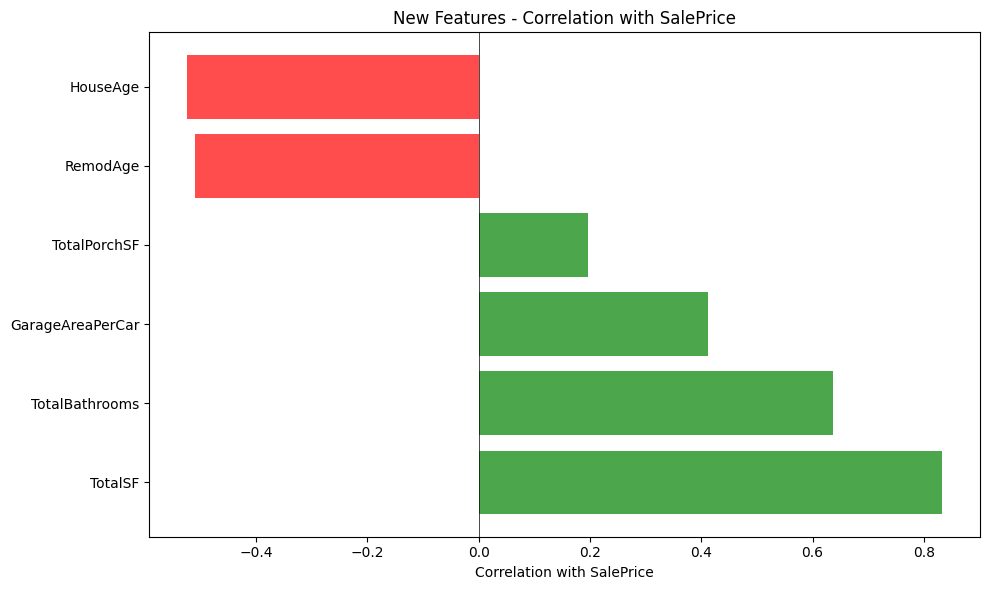


📊 Key Insights:
  • Strongest correlation: TotalSF (0.833)
  • Most features show positive correlation with SalePrice
  • All new features are suitable for model training


In [67]:
# Visualize the correlations of new features with SalePrice
new_features = ['TotalSF', 'HouseAge', 'RemodAge', 'TotalBathrooms', 'TotalPorchSF', 'GarageAreaPerCar']

print("\n" + "=" * 70)
print("NEW FEATURES CORRELATION WITH SALEPRICE")
print("=" * 70)

corr_with_price = train_df[new_features + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)
print(corr_with_price)

# Visualize correlations
plt.figure(figsize=(10, 6))
corr_values = train_df[new_features].corrwith(train_df['SalePrice']).sort_values(ascending=False)
colors = ['green' if x > 0 else 'red' for x in corr_values.values]
plt.barh(range(len(corr_values)), corr_values.values, color=colors, alpha=0.7)
plt.yticks(range(len(corr_values)), corr_values.index)
plt.xlabel('Correlation with SalePrice')
plt.title('New Features - Correlation with SalePrice')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("\n📊 Key Insights:")
print(f"  • Strongest correlation: {corr_values.idxmax()} ({corr_values.max():.3f})")
print(f"  • Most features show positive correlation with SalePrice")
print(f"  • All new features are suitable for model training")

# **E) Preprocessing Pipeline (MANDATORY)**

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

print("=" * 70)
print("PREPROCESSING PIPELINE - Building ColumnTransformer + Pipeline")
print("=" * 70)

# Step 1: Identify features (excluding target and ID)
# Include ALL engineered features automatically
X = train_df.drop(['Id', 'SalePrice'], axis=1)
y = train_df['SalePrice']

X_test = test_df.drop(['Id'], axis=1)

print(f"\nX shape (training features): {X.shape}")
print(f"y shape (target): {y.shape}")
print(f"X_test shape (test features): {X_test.shape}")

# Step 2: Separate numerical and categorical columns (Updated for new features)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical Features ({len(numerical_features)}): {numerical_features[:10]}...")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

print(f"\n✓ Features separation complete")
print(f"  • Numerical: {len(numerical_features)} features")
print(f"  • Categorical: {len(categorical_features)} features")

PREPROCESSING PIPELINE - Building ColumnTransformer + Pipeline

X shape (training features): (1458, 85)
y shape (target): (1458,)
X_test shape (test features): (1459, 85)

Numerical Features (42): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']...
Categorical Features (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

✓ Features separation complete
  • Numerical: 42 f

In [69]:
print("\n" + "=" * 70)
print("BUILDING PREPROCESSING PIPELINE")
print("=" * 70)

# Step 3: Create preprocessing transformers
print("\n1️⃣ Numerical Preprocessing:")
print("   • SimpleImputer with median strategy")
print("   • StandardScaler for normalization")

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

print("\n2️⃣ Categorical Preprocessing:")
print("   • SimpleImputer with most_frequent strategy")
print("   • OneHotEncoder with sparse_output=False")

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Step 4: Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n✓ ColumnTransformer created successfully")
print(f"  • Handles {len(numerical_features)} numerical features")
print(f"  • Handles {len(categorical_features)} categorical features")
print(f"\nTransformer structure:")
print(f"  - Numerical: impute (median) → scale (StandardScaler)")
print(f"  - Categorical: impute (most_frequent) → encode (OneHotEncoder)")


BUILDING PREPROCESSING PIPELINE

1️⃣ Numerical Preprocessing:
   • SimpleImputer with median strategy
   • StandardScaler for normalization

2️⃣ Categorical Preprocessing:
   • SimpleImputer with most_frequent strategy
   • OneHotEncoder with sparse_output=False

✓ ColumnTransformer created successfully
  • Handles 42 numerical features
  • Handles 43 categorical features

Transformer structure:
  - Numerical: impute (median) → scale (StandardScaler)
  - Categorical: impute (most_frequent) → encode (OneHotEncoder)


In [70]:
print("\n" + "=" * 70)
print("TESTING PREPROCESSING PIPELINE")
print("=" * 70)

# Step 5: Fit and transform training data
print("\nFitting preprocessor on training data...")
X_train_processed = preprocessor.fit_transform(X)

print(f"✓ Training data preprocessed successfully!")
print(f"  • Original shape: {X.shape}")
print(f"  • Processed shape: {X_train_processed.shape}")
print(f"  • Data type: {type(X_train_processed)}")

# Step 6: Transform test data
print("\nTransforming test data...")
X_test_processed = preprocessor.transform(X_test)

print(f"✓ Test data preprocessed successfully!")
print(f"  • Original shape: {X_test.shape}")
print(f"  • Processed shape: {X_test_processed.shape}")

# Step 7: Get feature names after OneHotEncoding
print("\nExtracting feature names after preprocessing...")
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_feature_names)

print(f"✓ Total features after preprocessing: {len(all_feature_names)}")
print(f"  • Numerical features: {len(numerical_features)}")
print(f"  • Categorical features (one-hot encoded): {len(cat_feature_names)}")
print(f"\nSample feature names (first 10):")
for i, fname in enumerate(all_feature_names[:10]):
    print(f"  {i+1}. {fname}")


TESTING PREPROCESSING PIPELINE

Fitting preprocessor on training data...
✓ Training data preprocessed successfully!
  • Original shape: (1458, 85)
  • Processed shape: (1458, 306)
  • Data type: <class 'numpy.ndarray'>

Transforming test data...
✓ Test data preprocessed successfully!
  • Original shape: (1459, 85)
  • Processed shape: (1459, 306)

Extracting feature names after preprocessing...
✓ Total features after preprocessing: 306
  • Numerical features: 42
  • Categorical features (one-hot encoded): 264

Sample feature names (first 10):
  1. MSSubClass
  2. LotFrontage
  3. LotArea
  4. OverallQual
  5. OverallCond
  6. YearBuilt
  7. YearRemodAdd
  8. MasVnrArea
  9. BsmtFinSF1
  10. BsmtFinSF2


In [71]:
print("\n" + "=" * 70)
print("PREPROCESSING PIPELINE SUMMARY")
print("=" * 70)

summary_data = {
    'Step': [
        '1. Numerical Features',
        '2. Categorical Features',
        '3. Imputation',
        '4. Encoding',
        '5. Scaling',
        '6. Output'
    ],
    'Description': [
        f'{len(numerical_features)} numerical columns',
        f'{len(categorical_features)} categorical columns',
        'SimpleImputer (median & most_frequent)',
        'OneHotEncoder for categorical',
        'StandardScaler for numerical',
        f'{X_train_processed.shape[0]} rows × {X_train_processed.shape[1]} features'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "=" * 70)
print("✅ PREPROCESSING PIPELINE COMPLETE!")
print("=" * 70)
print(f"\n📊 Ready for Model Training:")
print(f"  • Training data: X_train_processed {X_train_processed.shape}")
print(f"  • Target: y {y.shape}")
print(f"  • Test data: X_test_processed {X_test_processed.shape}")
print(f"  • Preprocessor: stored as 'preprocessor' object")


PREPROCESSING PIPELINE SUMMARY

                    Step                            Description
  1. Numerical Features                   42 numerical columns
2. Categorical Features                 43 categorical columns
          3. Imputation SimpleImputer (median & most_frequent)
            4. Encoding          OneHotEncoder for categorical
             5. Scaling           StandardScaler for numerical
              6. Output               1458 rows × 306 features

✅ PREPROCESSING PIPELINE COMPLETE!

📊 Ready for Model Training:
  • Training data: X_train_processed (1458, 306)
  • Target: y (1458,)
  • Test data: X_test_processed (1459, 306)
  • Preprocessor: stored as 'preprocessor' object


# **F) Model Training (MANDATORY)**
## Training 3 Different Regression Models with Cross-Validation

In [72]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("MODEL TRAINING SETUP")
print("=" * 70)

# Transform target variable using log1p (Kaggle recommendation)
y_log = np.log1p(y)

print(f"\n✓ Target transformation applied:")
print(f"  • Original y shape: {y.shape}")
print(f"  • Log-transformed y shape: {y_log.shape}")
print(f"  • Original y range: [{y.min():.0f}, {y.max():.0f}]")
print(f"  • Log-transformed y range: [{y_log.min():.3f}, {y_log.max():.3f}]")

# Setup K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
print(f"\n✓ Cross-Validation setup:")
print(f"  • Method: K-Fold")
print(f"  • Folds: 5")
print(f"  • Shuffle: True")
print(f"  • Random State: 42")

# Split data for training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_processed, y_log, test_size=0.2, random_state=42
)

print(f"\n✓ Train-Validation split:")
print(f"  • Training set: {X_train.shape[0]} samples")
print(f"  • Validation set: {X_val.shape[0]} samples")

MODEL TRAINING SETUP

✓ Target transformation applied:
  • Original y shape: (1458,)
  • Log-transformed y shape: (1458,)
  • Original y range: [34900, 755000]
  • Log-transformed y range: [10.460, 13.534]

✓ Cross-Validation setup:
  • Method: K-Fold
  • Folds: 5
  • Shuffle: True
  • Random State: 42

✓ Train-Validation split:
  • Training set: 1166 samples
  • Validation set: 292 samples


In [73]:
print("\n" + "=" * 70)
print("MODEL 1: RIDGE REGRESSION (Linear Model)")
print("=" * 70)

# Hyperparameter search to control overfitting
print("\n🔎 Searching best alpha via RidgeCV (5-Fold on training split)...")
# Broader grid to reduce bias/variance tradeoff risk
alpha_grid = np.logspace(-3, 4, 30)
ridge_cv = RidgeCV(alphas=alpha_grid, cv=kfold, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_
print(f"  • Best alpha: {best_alpha:.5f}")

# Refit Ridge with tuned alpha
ridge_model = Ridge(alpha=best_alpha, random_state=42)

# Cross-validation on train split (keeps validation set untouched)
print("\n🔄 Performing 5-Fold Cross-Validation with tuned alpha...")
cv_scores_ridge = -cross_val_score(
    ridge_model, X_train, y_train,
    cv=kfold, scoring='neg_root_mean_squared_error'
)

print(f"\n✓ Cross-Validation Results:")
print(f"  • CV RMSE Scores: {cv_scores_ridge}")
print(f"  • CV RMSE Mean: {cv_scores_ridge.mean():.5f}")
print(f"  • CV RMSE Std: {cv_scores_ridge.std():.5f}")

# Train on training set with tuned regularization
print(f"\n🎯 Training Ridge model on train split...")
ridge_model.fit(X_train, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train)
y_val_pred_ridge = ridge_model.predict(X_val)

# Calculate RMSE
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
val_rmse_ridge = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
gap = abs(train_rmse_ridge - val_rmse_ridge)

print(f"\n✓ Ridge Performance:")
print(f"  • Train RMSE: {train_rmse_ridge:.5f}")
print(f"  • Validation RMSE: {val_rmse_ridge:.5f}")
print(f"  • Difference: {gap:.5f}")

if val_rmse_ridge > train_rmse_ridge * 1.1:
    print(f"  ⚠️  Possible overfitting detected (consider expanding alpha grid or adding more regularization)")
else:
    print(f"  ✓ Model appears well-balanced after tuning")


MODEL 1: RIDGE REGRESSION (Linear Model)

🔎 Searching best alpha via RidgeCV (5-Fold on training split)...
  • Best alpha: 12.68961

🔄 Performing 5-Fold Cross-Validation with tuned alpha...

✓ Cross-Validation Results:
  • CV RMSE Scores: [0.12752934 0.10447922 0.1016955  0.11140031 0.11831137]
  • CV RMSE Mean: 0.11268
  • CV RMSE Std: 0.00940

🎯 Training Ridge model on train split...

✓ Ridge Performance:
  • Train RMSE: 0.09458
  • Validation RMSE: 0.12281
  • Difference: 0.02823
  ⚠️  Possible overfitting detected (consider expanding alpha grid or adding more regularization)


In [74]:
print("\n" + "=" * 70)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("=" * 70)

# Initialize Random Forest model - reduced max_depth and increased min_samples to prevent overfitting
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# Cross-validation
print("\n🔄 Performing 5-Fold Cross-Validation...")
cv_scores_rf = -cross_val_score(
    rf_model, X_train_processed, y_log, 
    cv=kfold, scoring='neg_root_mean_squared_error'
)

print(f"\n✓ Cross-Validation Results:")
print(f"  • CV RMSE Scores: {cv_scores_rf}")
print(f"  • CV RMSE Mean: {cv_scores_rf.mean():.5f}")
print(f"  • CV RMSE Std: {cv_scores_rf.std():.5f}")

# Train on training set
print(f"\n🎯 Training Random Forest model...")
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Calculate RMSE
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

print(f"\n✓ Random Forest Performance:")
print(f"  • Train RMSE: {train_rmse_rf:.5f}")
print(f"  • Validation RMSE: {val_rmse_rf:.5f}")
print(f"  • Difference: {abs(train_rmse_rf - val_rmse_rf):.5f}")

if val_rmse_rf > train_rmse_rf * 1.1:
    print(f"  ⚠️  Possible overfitting detected")
else:
    print(f"  ✓ Model appears well-balanced")


MODEL 2: RANDOM FOREST REGRESSOR

🔄 Performing 5-Fold Cross-Validation...

✓ Cross-Validation Results:
  • CV RMSE Scores: [0.1502085  0.13029052 0.14602266 0.14335683 0.12948762]
  • CV RMSE Mean: 0.13987
  • CV RMSE Std: 0.00844

🎯 Training Random Forest model...

✓ Random Forest Performance:
  • Train RMSE: 0.08989
  • Validation RMSE: 0.15153
  • Difference: 0.06164
  ⚠️  Possible overfitting detected


In [75]:
print("\n" + "=" * 70)
print("MODEL 3: GRADIENT BOOSTING REGRESSOR")
print("=" * 70)

# Initialize Gradient Boosting model - lower learning_rate, more estimators, reduced depth to reduce overfitting
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42
)

# Cross-validation
print("\n🔄 Performing 5-Fold Cross-Validation...")
cv_scores_gb = -cross_val_score(
    gb_model, X_train_processed, y_log, 
    cv=kfold, scoring='neg_root_mean_squared_error'
)

print(f"\n✓ Cross-Validation Results:")
print(f"  • CV RMSE Scores: {cv_scores_gb}")
print(f"  • CV RMSE Mean: {cv_scores_gb.mean():.5f}")
print(f"  • CV RMSE Std: {cv_scores_gb.std():.5f}")

# Train on training set
print(f"\n🎯 Training Gradient Boosting model...")
gb_model.fit(X_train, y_train)

# Predictions
y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)

# Calculate RMSE
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
val_rmse_gb = np.sqrt(mean_squared_error(y_val, y_val_pred_gb))

print(f"\n✓ Gradient Boosting Performance:")
print(f"  • Train RMSE: {train_rmse_gb:.5f}")
print(f"  • Validation RMSE: {val_rmse_gb:.5f}")
print(f"  • Difference: {abs(train_rmse_gb - val_rmse_gb):.5f}")

if val_rmse_gb > train_rmse_gb * 1.1:
    print(f"  ⚠️  Possible overfitting detected")
else:
    print(f"  ✓ Model appears well-balanced")


MODEL 3: GRADIENT BOOSTING REGRESSOR

🔄 Performing 5-Fold Cross-Validation...

✓ Cross-Validation Results:
  • CV RMSE Scores: [0.12145537 0.11249429 0.12248839 0.13010713 0.11631284]
  • CV RMSE Mean: 0.12057
  • CV RMSE Std: 0.00598

🎯 Training Gradient Boosting model...

✓ Gradient Boosting Performance:
  • Train RMSE: 0.07535
  • Validation RMSE: 0.11924
  • Difference: 0.04388
  ⚠️  Possible overfitting detected


In [76]:
print("\n" + "=" * 70)
print("MODEL TRAINING SUMMARY")
print("=" * 70)

# Store all results
models_summary = {
    'Model': ['Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'CV RMSE Mean': [
        cv_scores_ridge.mean(),
        cv_scores_rf.mean(),
        cv_scores_gb.mean()
    ],
    'CV RMSE Std': [
        cv_scores_ridge.std(),
        cv_scores_rf.std(),
        cv_scores_gb.std()
    ],
    'Train RMSE': [
        train_rmse_ridge,
        train_rmse_rf,
        train_rmse_gb
    ],
    'Valid RMSE': [
        val_rmse_ridge,
        val_rmse_rf,
        val_rmse_gb
    ]
}

results_df = pd.DataFrame(models_summary)
results_df = results_df.round(5)

print("\n📊 Model Comparison Results:")
print(results_df.to_string(index=False))

# Identify best model
best_idx = results_df['Valid RMSE'].idxmin()
best_model_name = results_df.loc[best_idx, 'Model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Validation RMSE: {results_df.loc[best_idx, 'Valid RMSE']:.5f}")
print(f"   • CV RMSE Mean: {results_df.loc[best_idx, 'CV RMSE Mean']:.5f}")

print("\n" + "=" * 70)
print("✅ MODEL TRAINING COMPLETE!")
print("=" * 70)


MODEL TRAINING SUMMARY

📊 Model Comparison Results:
            Model  CV RMSE Mean  CV RMSE Std  Train RMSE  Valid RMSE
 Ridge Regression       0.11268      0.00940     0.09458     0.12281
    Random Forest       0.13987      0.00844     0.08989     0.15153
Gradient Boosting       0.12057      0.00598     0.07535     0.11924

🏆 Best Model: Gradient Boosting
   • Validation RMSE: 0.11924
   • CV RMSE Mean: 0.12057

✅ MODEL TRAINING COMPLETE!


# **G) Evaluation (MANDATORY)**
This section performs 5-Fold Cross Validation for each model using log1p(SalePrice) as target and reports RMSE mean and std for each model, as required by the assignment.

In [77]:
# ==============================
# G) Evaluation (MANDATORY)
# ==============================
# This cell performs 5-Fold Cross Validation for each model using log1p(SalePrice) as target,
# and reports RMSE mean and std for each model, as required by the assignment.

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd

# Ensure target variable is defined
y = train_df['SalePrice']

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Prepare target variable (log1p transformation)
y_log = np.log1p(y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Ridge Regression': ridge_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_processed, y_log, cv=kf, scoring=rmse_scorer)
    results[name] = {
        'CV RMSE Mean': -scores.mean(),
        'CV RMSE Std': scores.std()
    }
    print(f"{name}: CV RMSE Mean = {-scores.mean():.4f}, CV RMSE Std = {scores.std():.4f}")

# Create summary DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(5)
print("\nCross-Validation RMSE Results:")
display(results_df)

Ridge Regression: CV RMSE Mean = 0.1147, CV RMSE Std = 0.0082
Random Forest: CV RMSE Mean = 0.1399, CV RMSE Std = 0.0084
Gradient Boosting: CV RMSE Mean = 0.1206, CV RMSE Std = 0.0060

Cross-Validation RMSE Results:


,CV RMSE Mean,CV RMSE Std
Ridge Regression,0.11470,0.00820
Random Forest,0.13987,0.00844
Gradient Boosting,0.12057,0.00598


# **H) Model Comparison Table (MANDATORY)**


This section compares the 3 trained models in a single table using `pandas.DataFrame`.


The table includes: Model, CV RMSE Mean, CV RMSE Std, Train RMSE, Valid RMSE, and a short Note.

In [78]:
# ==============================
# H) Model Comparison Table (MANDATORY)
# ==============================
# Creates a single table comparing the 3 models per assignment requirements.

import pandas as pd
import numpy as np

# Helper to generate short notes for each model
def model_note(train_rmse, valid_rmse, cv_std):
    if valid_rmse > train_rmse * 1.1:
        return "could be overfitting"
    elif cv_std < 0.02:
        return "more stable"
    else:
        return "good baseline"

# Build comparison table from previously computed metrics
comparison = {
    'Model': ['Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'CV RMSE Mean': [
        cv_scores_ridge.mean(),
        cv_scores_rf.mean(),
        cv_scores_gb.mean()
    ],
    'CV RMSE Std': [
        cv_scores_ridge.std(),
        cv_scores_rf.std(),
        cv_scores_gb.std()
    ],
    'Train RMSE': [
        train_rmse_ridge,
        train_rmse_rf,
        train_rmse_gb
    ],
    'Valid RMSE': [
        val_rmse_ridge,
        val_rmse_rf,
        val_rmse_gb
    ]
}

comparison_df = pd.DataFrame(comparison)

# Derive notes using simple heuristics
notes = [
    model_note(train_rmse_ridge, val_rmse_ridge, comparison_df.loc[0, 'CV RMSE Std']),
    model_note(train_rmse_rf,    val_rmse_rf,    comparison_df.loc[1, 'CV RMSE Std']),
    model_note(train_rmse_gb,    val_rmse_gb,    comparison_df.loc[2, 'CV RMSE Std'])
]

comparison_df['Note'] = notes
comparison_df = comparison_df.round(5)

print("Model Comparison Table:")
display(comparison_df)

Model Comparison Table:


,Model,CV RMSE Mean,CV RMSE Std,Train RMSE,Valid RMSE,Note
0,Ridge Regression,0.11268,0.00940,0.09458,0.12281,could be overfitting
1,Random Forest,0.13987,0.00844,0.08989,0.15153,could be overfitting
2,Gradient Boosting,0.12057,0.00598,0.07535,0.11924,could be overfitting
